# **Elaborato per il corso di Hands on Labs, MD2SL 2024**
## *Dario Comanducci*

# Introduzione
Si vuole implementare una rete convoluzionale per un'applicazione di super-risoluzione, prendendo spunto dal lavoro descritto in: 

C. Dong, C.C. Loy, K. He and X. Tang, "Image Super-Resolution Using Deep Convolutional Networks," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 38, no. 2, pp. 295-307, 1 Feb. 2016.

A differenza del paper citato, sviluppato su immagini di carattere generale, si vuole qui adattare l'addestramento della rete alla ricostruzione a maggiore qualità di immagini di volti a bassa risoluzione.

## Il dataset
Per fare ciò, è stato impiegato il dataset *CelebA* (https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), nella versione "semplificata" in cui i volti sono stati allineati rispetto alla posizione degli occhi in immagini di dimensione costante 218$\times$178, a differenza del dataset originale con foto scattate "in the wild": mentre Dong et al. avevano addestrato la propria rete su immagini di carattere generale, si vuole qui cercare di applicare la stessa impostazione su foto di volti.

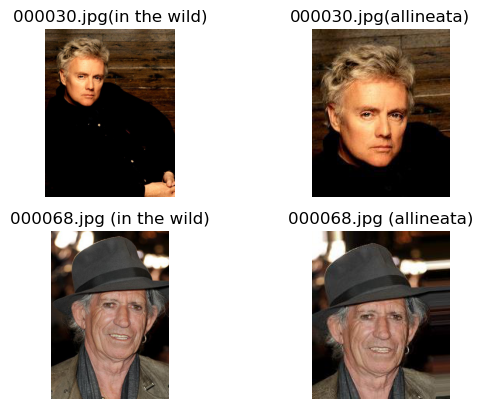

In [1]:
from PIL import Image
from os import path

import matplotlib.pyplot as plt
import numpy as np

orig_path = 'C:/Users/dario/Documents/Projects/Master/HandsOnLab/CelebA/img_celeba'
img_path = 'C:/Users/dario/Documents/Projects/Master/HandsOnLab/img_align_celeba/'
fid1 = '000030.jpg'
fid2 = '000068.jpg'
img1o = Image.open(path.join(orig_path, fid1))
img1a = Image.open(path.join(img_path, fid1))
img2o = Image.open(path.join(orig_path, fid2))
img2a = Image.open(path.join(img_path, fid2))


fig = plt.figure() #figsize=(8, 8)
ax = fig.add_subplot(2, 2, 1)
plt.imshow(np.array(img1o))
ax.set_axis_off()
ax.set_title(fid1 + '(in the wild)')
ax = fig.add_subplot(2, 2, 2)
plt.imshow(np.array(img1a))
ax.set_title(fid1 + '(allineata)')
ax.set_axis_off()
#
ax = fig.add_subplot(2, 2, 3)
plt.imshow(np.array(img2o))
ax.set_axis_off()
ax.set_title(fid2 + ' (in the wild)')
ax = fig.add_subplot(2, 2, 4)
plt.imshow(np.array(img2a))
ax.set_title(fid2 + ' (allineata)')
ax.set_axis_off()
plt.show()

Oltre alle 202599 immagini, il dataset è corredato da una serie di file con annotazioni per ciascuna foto: in particolare,
* list_eval_partition.txt, con la ripartizione delle immagini in traning set, validation set e test set;
* list_attr_celeba.txt, contenente una serie di attributi binari per ciascuna immagine;
* identity_CelebA.txt, con dei codici numerici identificativi di ogni soggetto ritratto in ciascuna foto.

L'importazione delle informazioni a contorno è stata effettuata tramite pandas, caricando inizialmente i tre file di testo in tre distinti dataframe (df_part, df_attr, df_subj), ognuno con chiave di ogni riga data dal nome della relativa immagine, e poi unificati in un unico dataframe df, tramite il metodo concat di pandas. 

Illustriamo di seguito le informazioni contenute, caratterizzanti le immagini del dataset.


In [2]:
# importazione librerie
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import matthews_corrcoef

# cartella di lavoro
fpath = 'C:/Users/dario/Documents/Projects/Master/HandsOnLab/CelebA/'

# uso il nome dell'immagine come chiave in tutti e 3 i dataframe;
# nella prima riga di list_attr_celeba.txt viene indicato solo il numero complessivo di esempi, per cui skiprows=1
df_attr = pd.read_csv(fpath + 'Anno/list_attr_celeba.txt', sep="\s+", index_col=0, skiprows=1) 
df_subj = pd.read_csv(fpath + 'Anno/identity_CelebA.txt',  sep=" ",   index_col=0, header=None, names=['subject'])
df_part = pd.read_csv(fpath + 'list_eval_partition.txt',   sep=" ",   index_col=0, header=None, names=['set'])
df = pd.concat([df_part, df_subj, df_attr], axis=1)

# converto binarie da {-1,1} a {0,1}
bin_vars = df_attr.columns
df[bin_vars] = (df[bin_vars]+1)//2
# converto df.set da {0,1,2} in {'train','valid','test'}
set_labels = {0: 'train', 1: 'valid', 2: 'test'}
df['set'] = df['set'].replace(set_labels)

print('_____________________________________________________________________________________________________________________')
print('dataframe df_attr:')
print(df_attr.head())
print('_____________________________________________________________________________________________________________________')
print('dataframe df_subj:')
print(df_subj.head())
print('_____________________________________________________________________________________________________________________')
print('dataframe df_part:')
print(df_part.head())
print('_____________________________________________________________________________________________________________________')
print('dataframe df:')
print(df.head())

_____________________________________________________________________________________________________________________
dataframe df_attr:
            5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
000001.jpg                -1                1           1               -1   
000002.jpg                -1               -1          -1                1   
000003.jpg                -1               -1          -1               -1   
000004.jpg                -1               -1           1               -1   
000005.jpg                -1                1           1               -1   

            Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...  \
000001.jpg    -1     -1        -1        -1          -1          -1  ...   
000002.jpg    -1     -1        -1         1          -1          -1  ...   
000003.jpg    -1     -1         1        -1          -1          -1  ...   
000004.jpg    -1     -1        -1        -1          -1          -1  ...   
000005.jpg    

### Caratterizzazione dei volti
Iniziamo a descrivere gli attributi impiegati per caratterizzare i volti delle persone nel dataset (purtoppo mancano indicazioni sull'etnia delle persone)

In [3]:
print(bin_vars)

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')


Per semplicità, viene riportata di seguito una tabella con la traduzione in italiano di ciascuna caratteristica

| caratteristica   | traduzione            |  •  | caratteristica      | traduzione               |
|---               |---                    |---  |---                  |---                       |
| 5_o_Clock_Shadow | leggera barbetta      |  •  |  Male               | Maschio                  |
| Arched_Eyebrows  | Sopracciglia arcuate  |  •  | Mouth_Slightly_Open | Bocca leggermente aperta |
| Attractive       | Attraente             |  •  | Mustache            | Baffi                    |
| Bags_Under_Eyes  | Borse sotto gli occhi |  •  | Narrow_Eyes         | Occhi a mandorla         |
| Bald             | Calvo/a               |  •  | No_Beard            | Nessuna barba            |
| Bangs            | Frangia               |  •  | Oval_Face           | Faccia ovale             |
| Big_Lips         | Grandi labbra         |  •  | Pale_Skin           | Pelle pallida            |
| Big_Nose         | Naso grande           |  •  | Pointy_Nose         | Naso a punta             |
| Black_Hair       | Capelli neri          |  •  | Receding_Hairline   | Stempiato/a              |
| Blond_Hair       | Capelli biondi        |  •  | Rosy_Cheeks         | Guance rosa              |
| Blurry           | Sfuocata              |  •  | Sideburns           | Basette                  |
| Brown_Hair       | Capelli castani       |  •  | Smiling             | Sorridente               |
| Bushy_Eyebrows   | Sopracciglia folte    |  •  | Straight_Hair       | Capelli lisci            |
| Chubby           | Paffuto/a             |  •  | Wavy_Hair           | Capelli mossi            |
| Double_Chin      | Doppio mento          |  •  | Wearing_Earrings    | Indossa orecchini        |
| Eyeglasses       | Occhiali              |  •  | Wearing_Hat         | Indossare il cappello    |
| Goatee           | Pizzo                 |  •  | Wearing_Lipstick    | Porta il rossetto        |
| Gray_Hair        | Capelli grigi         |  •  | Wearing_Necklace    | Indossa collane          |
| Heavy_Makeup     | Trucco pesante        |  •  | Wearing_Necktie     | Indossa la cravatta      |
| High_Cheekbones  | Zigomi alti           |  •  | Young               | Giovane                  |


Tali attributi sono così ripartiti all'interno del dataset

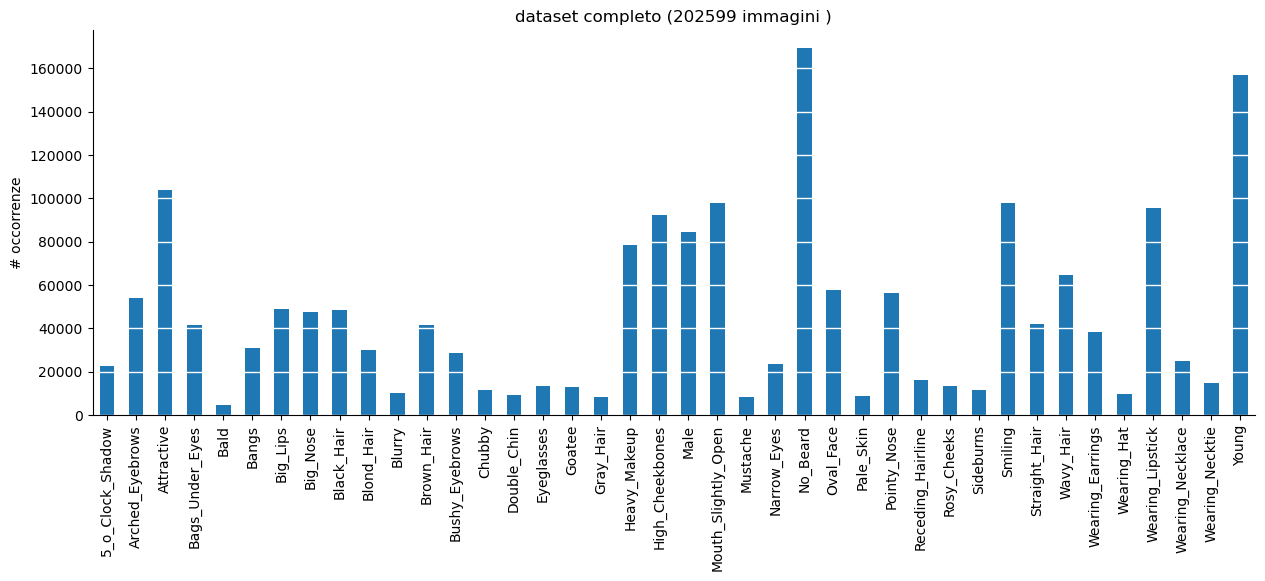

In [4]:
def featureBarplot(feature, ax, title=None, ylabel=None, ylim=None):
    feature.plot( kind='bar', ax=ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', color='white', linewidth=1)
    if (title != None):
        ax.set_title(title)
    if (ylabel != None):
        ax.set_ylabel(ylabel)
    if (ylim != None):
        ax.set_ylim(ylim)

#-----------------------------------------------------------------------------------------------------------------------------

colsums_Full  = df[bin_vars].sum(axis=0)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
featureBarplot(colsums_Full,ax,'dataset completo (' + str(df.shape[0]) + ' immagini )', '# occorrenze')
plt.show()

Possiamo inoltre valutare quanto le caratteristiche riportate siano "correlate" tra loro. Trattandosi di variabili binarie, in sostituzione dell'indice di correlazione di Pearson si è impiegato il *coefficiente di correlazione di Matthews (MCC)*, definito come
\begin{equation}
\phi = \frac{n_{11}\,n_{00} - n_{01}\,n_{10}}{\sqrt{n_{00}\, n_{01}\, n_{10}\, n_{11}}}
\end{equation}

(https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)

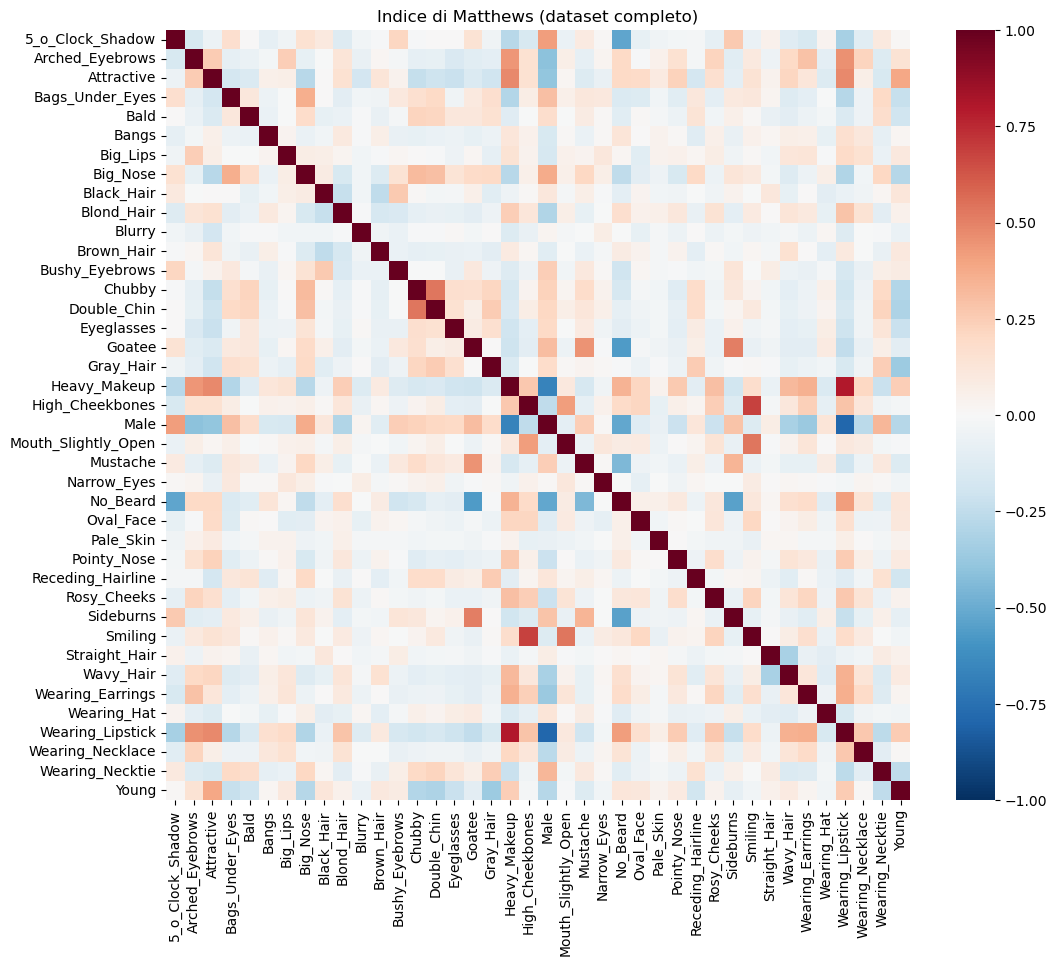

In [8]:
def computeScatterMCC(df, bin_vars):
    n_binaries = len(bin_vars)
    hmap_BinCorr  = np.ones((n_binaries,n_binaries))
    for i in range(n_binaries):
        xi = df[bin_vars[i]]
        for j in range(i+1,n_binaries):
            xj = df[bin_vars[j]]
            hmap_BinCorr[j,i]  = hmap_BinCorr[i,j]  = matthews_corrcoef(xi, xj)
    return hmap_BinCorr

#-----------------------------------------------------------------------------------------------------------------------------

hmap_BinCorr_Full = computeScatterMCC(df, bin_vars)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(pd.DataFrame(hmap_BinCorr_Full,index=bin_vars,columns=bin_vars), annot=False, cmap='RdBu_r', vmin=-1, vmax=1, ax=ax)
ax.set_title('Indice di Matthews (dataset completo)')
plt.show()

Il coefficiente di Matthews in effetti sembra fornire risultati sensati; ad esempio:
* 'Wearing_Lipstick' è correlata positivamente con 'Heavy_Makeup' e 'Attractive', mentre lo è molto negativamente con 'Male';
* 'No_Beard' è correlata negativamente con 'Goatee' e '5_o_Clock_Shadows' (la barbetta cresciuta nel tardo pomeriggio), così come con 'Sideburns';
* 'Smiling' è fortemente correlata con 'High_Cheekbones' e 'Mouth_Slightly_Open';
* 'Double_Chin' è correlato con 'Chubby'.

### Partizione del dataset

Il dataset viene presentato già diviso nelle tre usuali parti in un contesto di Machine Learning: *training set* (162770 elementi), *validation set* (19867 elementi) e *test set* (19962 elementi).

In [9]:
idTrain = df[df['set'] == 'train'].index; print('Training set: ' + str(len(idTrain)) + ' elementi')
idValid = df[df['set'] == 'valid'].index; print('Validation set: ' + str(len(idValid)) + ' elementi')
idTest  = df[df['set'] == 'test' ].index; print('Test set: ' + str(len(idTest)) + ' elementi')


Training set: 162770 elementi
Validation set: 19867 elementi
Test set: 19962 elementi


Confrontiamo come le caratteristiche delle immagini si ripartiscono all'interno dei tre dataset.
Iniziamo con le frequenze esibite da ciascuna caratteristica nei vari insiemi di dati

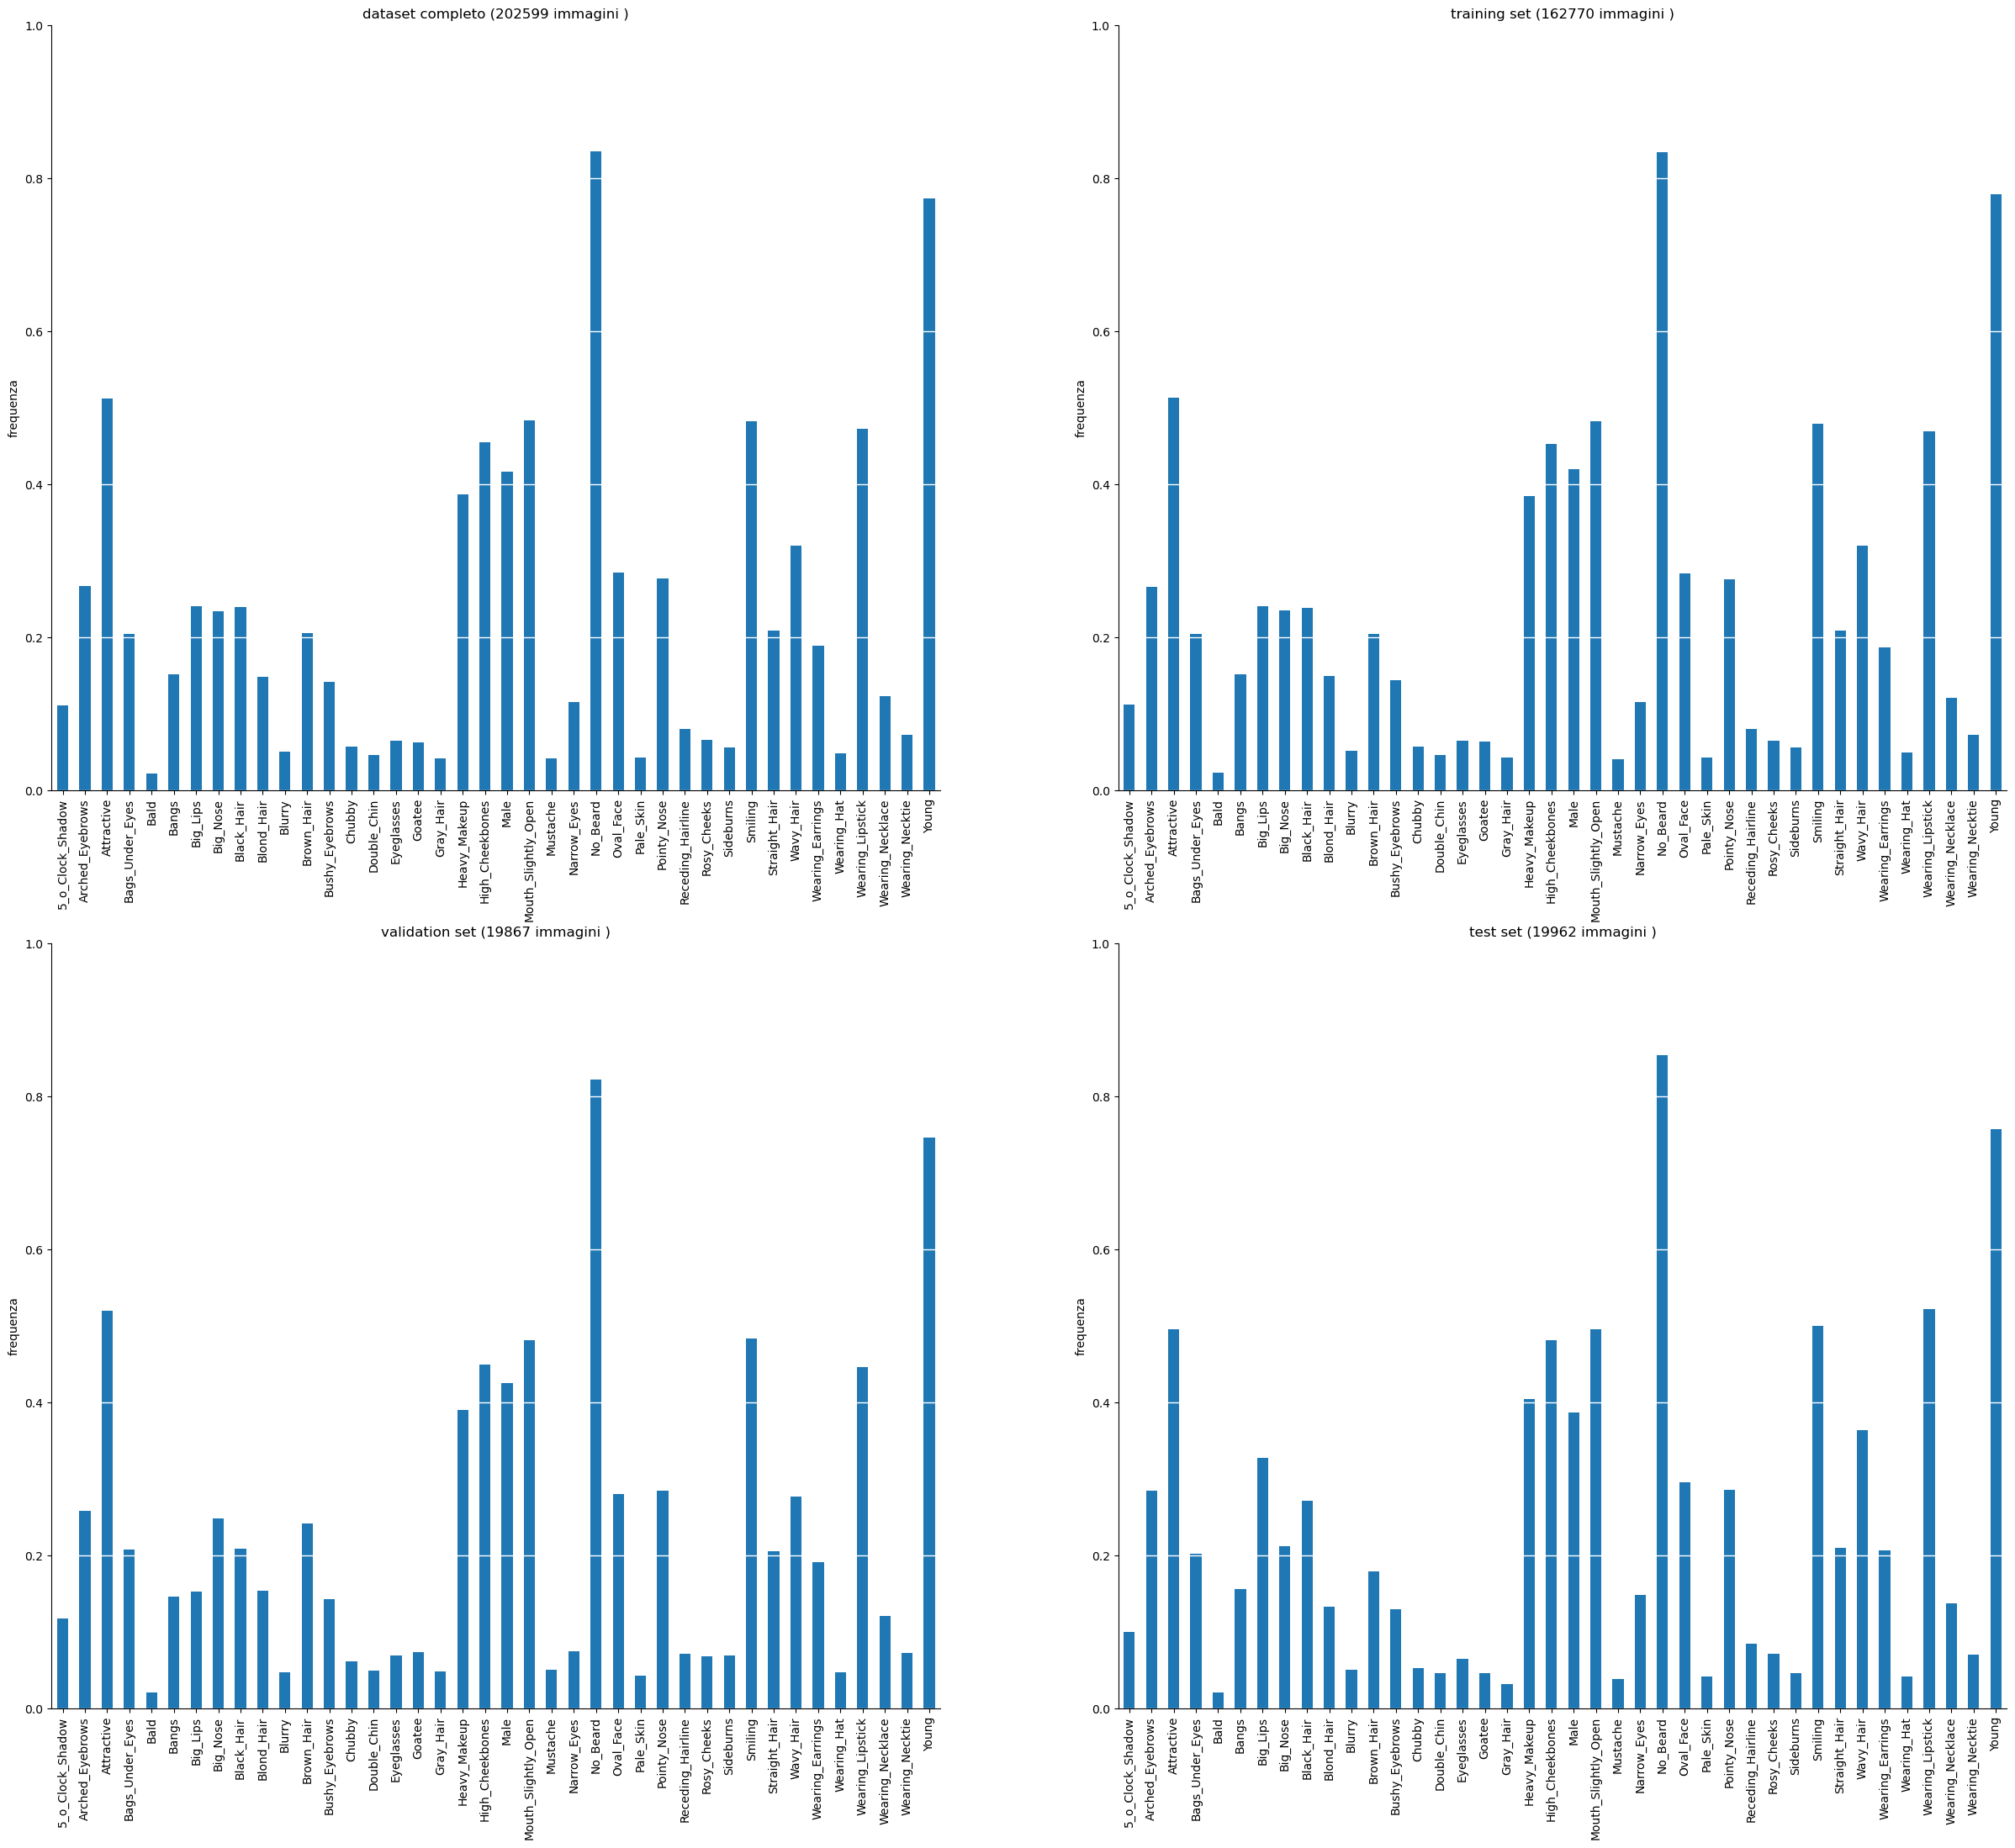

In [10]:
colFreqs_Full  = colsums_Full/df.shape[0]
colFreqs_Train = df.loc[idTrain,bin_vars].sum(axis=0)/len(idTrain)
colFreqs_Valid = df.loc[idValid,bin_vars].sum(axis=0)/len(idValid)
colFreqs_Test  = df.loc[idTest, bin_vars].sum(axis=0)/len(idTest)

fig, axes = plt.subplots(2,2, figsize=(30, 26))
featureBarplot(colFreqs_Full,  axes[0,0], 'dataset completo (' + str(df.shape[0]) + ' immagini )', 'frequenza', ylim=(0,1))
featureBarplot(colFreqs_Train, axes[0,1], 'training set (' + str(len(idTrain)) + ' immagini )', 'frequenza', ylim=(0,1))
featureBarplot(colFreqs_Valid, axes[1,0], 'validation set (' + str(len(idValid)) + ' immagini )', 'frequenza', ylim=(0,1))
featureBarplot(colFreqs_Test,  axes[1,1], 'test set (' + str(len(idTest)) + ' immagini )', 'frequenza', ylim=(0,1))
plt.show()

Gli istogrammi mostrano frequenze relative paragonabili. A conferma che la ripartizione proposta distribuisce piuttosto equamente le immagini, valutiamo anche la matrice di "contingenza" sui tre set, confrontando il risultato con il dataset completo.

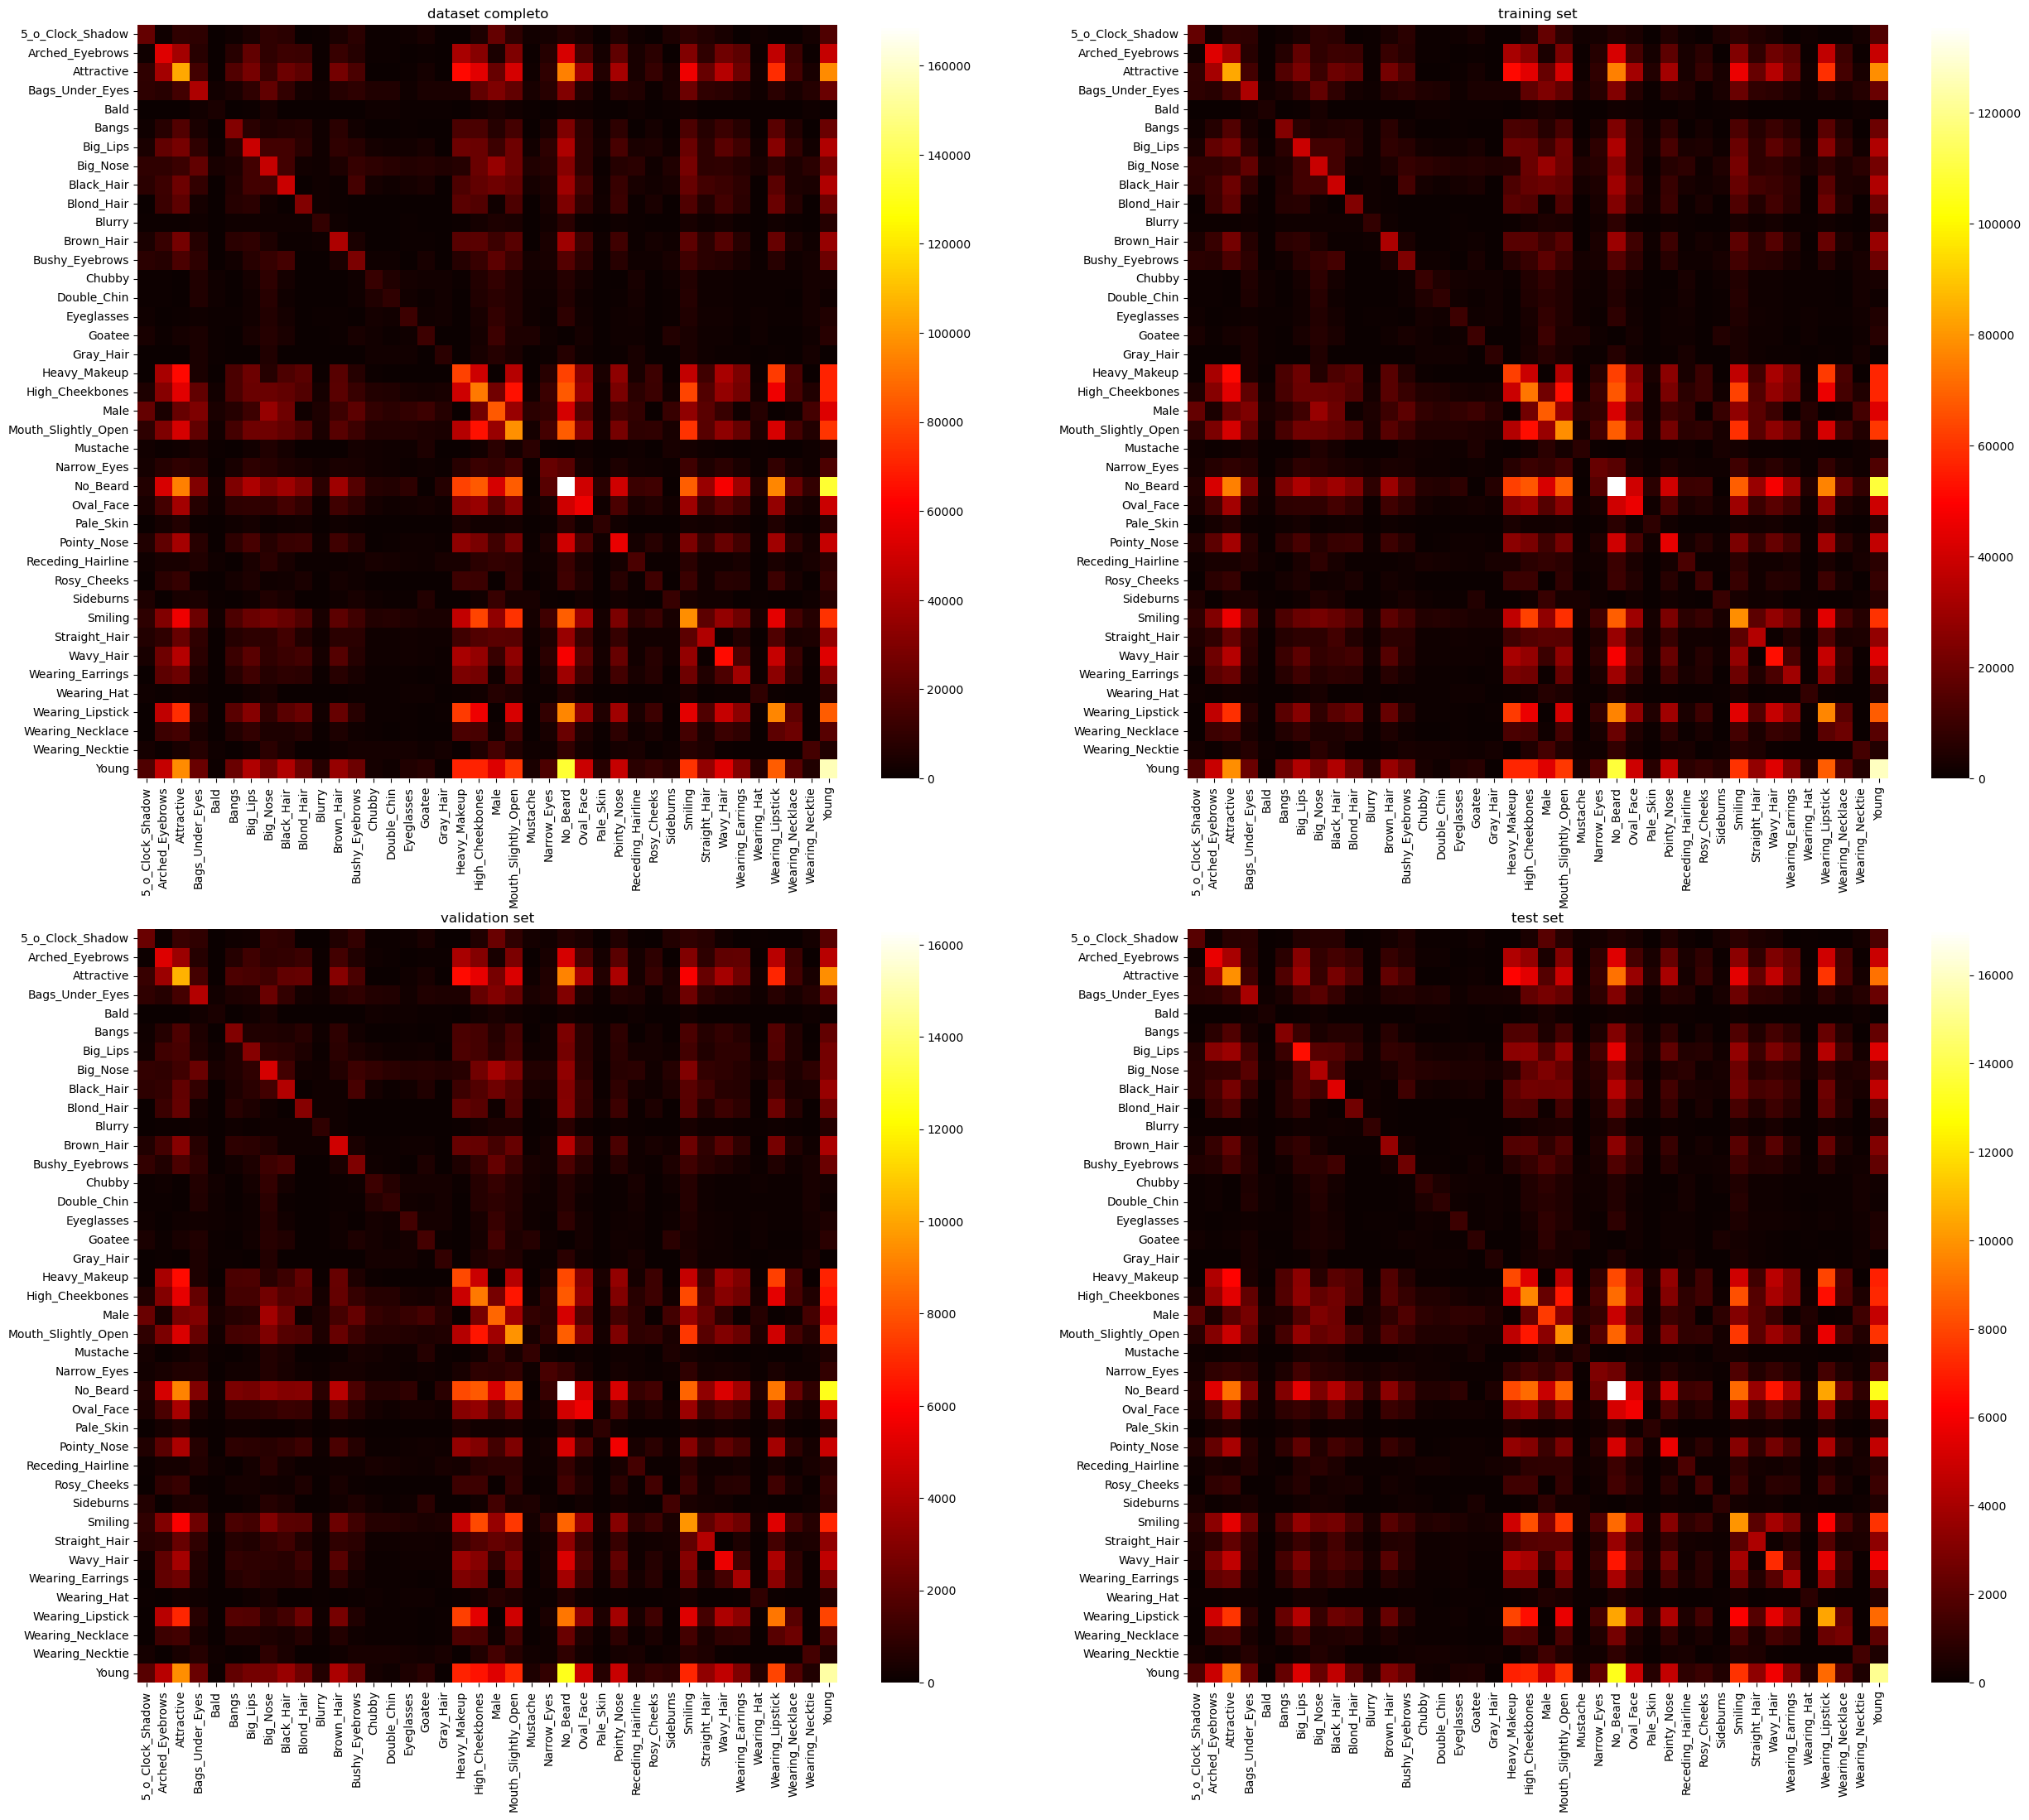

In [11]:
cmap_Full  = np.dot(df[bin_vars].T, df[bin_vars])
cmap_Train = np.dot(df.loc[idTrain,bin_vars].T, df.loc[idTrain,bin_vars])
cmap_Valid = np.dot(df.loc[idValid,bin_vars].T, df.loc[idValid,bin_vars])
cmap_Test  = np.dot(df.loc[idTest, bin_vars].T, df.loc[idTest, bin_vars])

fig, axes = plt.subplots(2,2, figsize=(30, 26))
sns.heatmap(pd.DataFrame(cmap_Full, index=bin_vars,columns=bin_vars), annot=False, cmap='hot', vmin=0, ax=axes[0,0])
sns.heatmap(pd.DataFrame(cmap_Train,index=bin_vars,columns=bin_vars), annot=False, cmap='hot', vmin=0, ax=axes[0,1])
sns.heatmap(pd.DataFrame(cmap_Valid,index=bin_vars,columns=bin_vars), annot=False, cmap='hot', vmin=0, ax=axes[1,0])
sns.heatmap(pd.DataFrame(cmap_Test, index=bin_vars,columns=bin_vars), annot=False, cmap='hot', vmin=0, ax=axes[1,1])
axes[0,0].set_title('dataset completo')
axes[0,1].set_title('training set')
axes[1,0].set_title('validation set')
axes[1,1].set_title('test set')
plt.show()

Infine, valutiamo di quanti soggetti distinti è composto ciascun set (dalla documentazione, le foto relative ad uno stesso individuo afferiscono ad un solo dei tre insiemi)

In [12]:
subjTrain = df.loc[idTrain,'subject'].drop_duplicates()
subjValid = df.loc[idValid,'subject'].drop_duplicates()
subjTest  = df.loc[idTest, 'subject'].drop_duplicates()

print('soggetti nel training set: '   + str(subjTrain.shape[0]))
print('soggetti nel validation set: ' + str(subjValid.shape[0]))
print('soggetti nel test set: '       + str(subjTest.shape[0]))

print('soggetti comuni tra training e validation set: '   + str( len(set(subjTrain) & set(subjValid)) ))
print('soggetti comuni tra training e test set: '         + str( len(set(subjTrain) & set(subjTest)) ))
print('soggetti comuni tra test e validation set: '       + str( len(set(subjTest)  & set(subjValid)) ))

soggetti nel training set: 8192
soggetti nel validation set: 985
soggetti nel test set: 1000
soggetti comuni tra training e validation set: 0
soggetti comuni tra training e test set: 0
soggetti comuni tra test e validation set: 0
